# Hackathon

We would like to have a guide which sets an optimal path between attractions in the fun-park so that users do not have to wait in queues too much.

<img src="fun_park_with_attractions.png" alt="Drawing" style="width: 70%;"/>

### What we have:
* walking distance in minutes between attractions
* number of users which can be served by each attraction per hour
* measurements from sensors of queue sizes to each attraction

### What we want to do:
* gather historical data from sensors
* run time-series prediction to find out queue sizes to each attraction over the next day
* run an algorithm to find the proper path (traveling salesman problem)

### What will participants of the hackathon do:
* get data from sensors, or use our generated data (second option is if we do not manage the first one)
* send the data to our webservice which runs time series prediction and get the estimated times for the next whole day
* send the data to our webservice which finds the proper path between attractions given the waiting times
* display the results in a user-friendly way in the mobile application

In [3]:
# imports
%matplotlib inline
import sys
import numpy as np
import datetime
from random import randint
import time
import math
import random

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from statsmodels.tsa.arima_model import ARIMA

from scipy.stats import norm
from matplotlib import pyplot

import pandas as pd
from pandas.tools.plotting import autocorrelation_plot
from pandas import DataFrame
from pandas import Series

# import of own files
from Cebit_TSP.qlearning import q_learning
from Cebit_Timeseries_Forecast.random_forest_forecast_class import RandomForestForecast
from arima_forecast_class import ArimaForestForecast

### Walking distance rewards

Walking distance rewards are numbers of minutes of walking between attractions. Rewards are negative and later we want to minimize the total number of negative rewards. 

The reward table is of shape `[n+2 rows x n+2 columns]`, where `n` is the number of attractions, and we add 2 as there is the start state and the end state. The invalid state contains number 0.

* We cannot come back to the same state twice so the diagonal of the matrix contains zeros
* We cannot go directly to the exit so the state [0, n+1] = 0
* Once we reached the end state, we do not go back so, the last row contains zeros [n+1,:] = 0

In [4]:
rewards = pd.read_csv('example/demo_rewards.csv', header=None)
rewards = abs(rewards) * -1

print("Test rewards:")
print(rewards)

Test rewards:
     0    1    2    3
0    0 -150 -145    0
1 -150    0 -132 -132
2 -145 -132    0 -134
3    0    0    0    0


In [5]:
rewards = pd.read_csv('example/walking_rewards.csv', header=None)
rewards = abs(rewards) * -1

print("Real walking rewards:")
print(rewards)

Real walking rewards:
        0       1       2       3       4       5       6       7       8   \
0   -0.000  -3.936  -9.084 -14.604 -17.172 -23.592 -25.944 -23.868 -21.372   
1   -3.936  -0.000  -4.992 -10.452 -13.080 -19.500 -21.852 -19.800 -17.280   
2   -9.084  -4.992  -0.000  -5.520  -8.100 -14.508 -16.860 -14.748 -12.324   
3  -14.604 -10.452  -5.520  -0.000  -2.616  -9.036 -11.388  -9.324  -6.852   
4  -17.172 -13.080  -8.100  -2.616  -0.000  -6.420  -8.772  -6.708  -4.212   
5  -23.592 -19.500 -14.508  -9.036  -6.420  -0.000  -2.676  -5.100  -4.008   
6  -25.944 -21.852 -16.860 -11.388  -8.772  -2.676  -0.000  -2.424  -4.596   
7  -23.868 -19.800 -14.748  -9.324  -6.708  -5.100  -2.424  -0.000  -2.508   
8  -21.372 -17.280 -12.324  -6.852  -4.212  -4.008  -4.596  -2.508  -0.000   
9  -19.056 -14.964  -9.888  -4.500  -4.260  -4.896  -6.888  -4.824  -2.292   
10 -20.424 -16.296 -11.340  -5.868  -5.436  -6.192  -5.520  -3.456  -2.244   
11 -20.856 -16.764 -11.772  -6.228  -8.100

In [6]:
attractions_throughput = pd.read_csv('example/attractions_throughput.csv', header=None)

print("Attractions Throughput - number of people that each attraction can serve per hour")
print(attractions_throughput)


Attractions Throughput - number of people that each attraction can serve per hour
       0
0   1080
1   1620
2    200
3    720
4   1450
5   1500
6   1800
7    290
8    570
9    400
10  2000
11   600
12   400
13  1600
14   400
15   900
16  1050
17   510
18   500


### Generated sensor measurements of queue size for each attraction

We assume that the proper distribution which describes the queue size length for each attraction over a whole day is a Gaussian. Each attraction has a separate distribution with a different mean and standard deviation. Additionally, some noise was introduced.

In the beginning, I generated sensors data every minute but then realized that this process is too slow and that time series forecast does not handle it well. For these reasons, I generate the sensors data every 5 minutes. We can maybe increase it to 10 minutes, such granularity should be sufficient. 

During holidays/weekends, I just multiplied the number of users by 1.5 for each attraction at each point in time.

To generate data, I run the following script `queue_pusher.py` and it saves the data to `queue_sizes.csv`

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  after removing the cwd from sys.path.


Plot of generated sensor data from one day


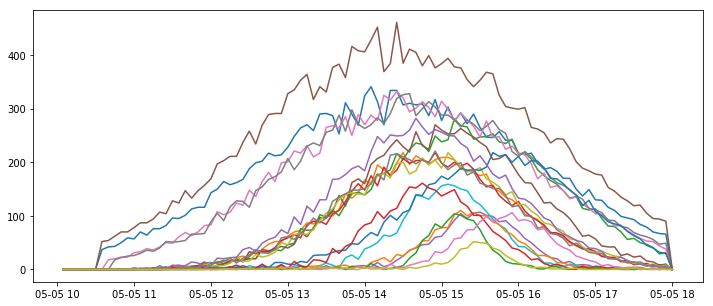

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  # This is added back by InteractiveShellApp.init_path()


Plot of generated sensor data from two days


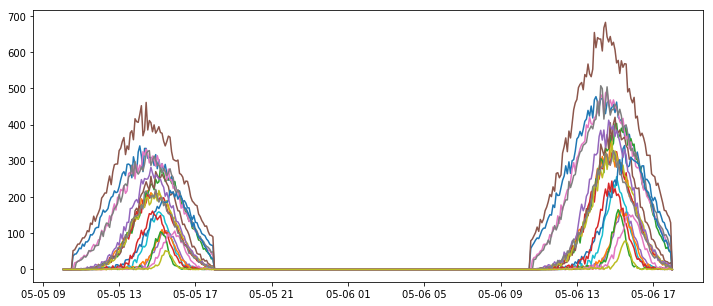

In [7]:
%matplotlib inline
pyplot.rcParams["figure.figsize"] =(12,5) 

data_frame = DataFrame.from_csv('Cebit_Datagenerator/queue_sizes.csv', header=0) # car-sales.csv
data_frame = data_frame[:int(480/5)]
pyplot.plot(data_frame)

print("Plot of generated sensor data from one day")
pyplot.show()

data_frame = DataFrame.from_csv('Cebit_Datagenerator/queue_sizes.csv', header=0) # car-sales.csv
data_frame = data_frame[:int(2*480/5)]
pyplot.plot(data_frame)
print("Plot of generated sensor data from two days")
pyplot.show()

### Time series predictor

I decided to experiment with relatively simple methods. I used random forest (time delayed estimator) and ARIMA model. After some experiments, I noticed that I am able to predict future queue sizes with Random Forest quite well, however, the ARIMA model did not work well for me. Do not know why sth to check if we have time.

I did not use any sophisticated methods like recurrent neural networks as this is just a POC.

##### Time delay estimation
What is the idea of time delay estimation? Imagine that we have a time series 

|1 | 2  |   3|   4|   5|   6|   7|   8|   9|  10|
|--|----|----|----|----|----|----|----|----|----|
|t | t+1| t+2| t+3| t+4| t+5| t+6| t+7| t+8| t+9|

The ML model would take a part of the given sequence as input and try to learn the output for it. Let's assume that it takes as an input a window of size 3 at each discrete point of time. At the next point in time, the window is moved by one time step - this approach is called a sliding window.
* Input: [1, 2, 3] -> Output: [4]
* Input: [2, 3, 4] -> Output: [5] 
* Input: [3, 4, 5] -> Output: [6]
* Input: [4, 5, 6] -> Output: [7]
* Input: [5, 6, 7] -> Output: [8]
* Input: [6, 7, 8] -> Output: [9]
* Input: [7, 8, 9] -> Output: [10]

The ML algorithm will try to predict the best possible label for each set of values contained in a sliding window.

### Random Forest

Random Forest is a supervised learning algorithm. It builds a set of decision trees from randomly selected features for each tree and then makes a prediction based on average from all decision trees.

<img src="decision_tree.png" alt="Drawing" style="width: 70%;"/>

Steps to create a random forest:
* Randomly select “K” features from total “m” features where k << m
* Among the “K” features, calculate the node “d” using the best split point
* Split the node into children nodes using the best split
* Repeat the steps until “l” number of nodes has been reached
* Build forest by repeating the above steps to create “n” number of trees

Easy to use machine learning algorithm that produces, even without hyper-parameter tuning, a great result most of the time. 

/Users/d069325/q-learning/q-learning/Cebit_Timeseries_Forecast/random_forest_forecast_class.py:23: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  data_frame = DataFrame.from_csv(filename, header=0) # car-sales.csv


trainning started for attraction: 1
trainning finished for attraction: 1
predict ahead started for attraction: 1
predict ahead finished for attraction: 1
Test MSE: 958.036


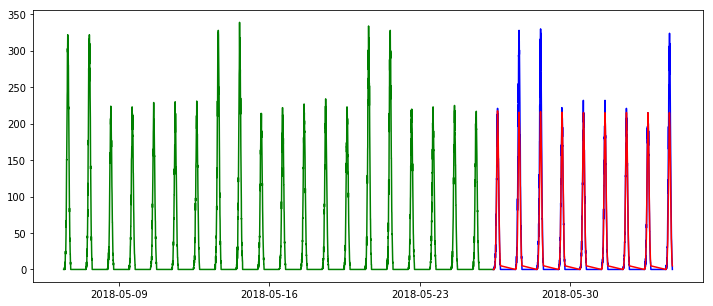

In [10]:
from Cebit_Timeseries_Forecast.random_forest_forecast_class import RandomForestForecast
from matplotlib import pyplot
%matplotlib inline
pyplot.rcParams["figure.figsize"] =(12,5) 

estimator = RandomForestForecast('Cebit_Timeseries_Forecast/queue_sizes.csv', 1, 96)
estimator.train()
estimator.predict_look_ahead(estimator.test_set_size)
estimator.display_results()

### Reinforcement Learning - Q-learning

Reinforcement learning is an important type of Machine Learning where an agent learns how to behave in an environment by performing actions and seeing the results - `master of brute-force`. The agent obtains rewards after performing each action and the goal of the agent is to maximize a sum of obtained rewards and reach the end state. After sufficiently many iterations, the agent chooses the actions which really lead to maximization of rewards.

<img src="reinforcement_learning.jpg" alt="Drawing" style="width: 70%;"/>

Q-learning is a technique that evaluates which action to take based on an action-value function that determines the value of being in a certain state and taking a certain action in that state.

Components:
* States - available positions which the agent can enter
* Rewards table - rewards which the agent gets when entering a certain state from a certain state. The easiest way to represent it is through an adjacency matrix where the values represent rewards.
* Function Q - takes as an input one state and one action and returns the expected reward of that action (and all subsequent actions) at that state. At the beginning of the algorithm, it is set to 0.

As we explore the environment (generate episodes in which agent tries to reach a goal), Q function gives us a better and better approximation of the value of an action a at a state s. We update our function Q as we go.

First, an important concept, the return G_t at time t is defined as the sum of rewards

G_t = R_{t} + R_{t+1} + ... + R_{T}

A discount factor ($\gamma$) is used in practice to balance between immediate and long term rewards:

G_t = R_{t} + $\gamma$ ^2 * R_{t+1} + ... + $\gamma$^{T-1} * R_{T}

The overall goal of a reinforcement learning algorithm is to maximize the discounted expected return for a sequence of actions. More formally, for an action a_t, if we knew the function:

Q(s_t, a_t) = E[G_t|s_t, a_t]

where E[G_t|s_t, a_t] is the expectation of return (G_t) at time t given we took action a_t at state s_t

One easy solution would be to simply enumerate all possible paths and then compute the value of Q(a_t) exactly. The problem is that this is is not feasible except for very small problems.

The Q-Learning algorithm allows approximating this function by exploiting the difference between its current value and best possible value for the next state:

Q(s_t, a_t) = Q(s_t, a_t) + $\alpha$ * [R_t + $\gamma$ * max_a(Q(s_{t+1}, a_t) - Q(s_t, a_t))]

### Traveling Salesman Problem

It is an optimization problem in which we want to find a minimum cost of traveling between all states. We used the q-learning algorithm in which rewards are represented as an adjacency matrix [n x n] where n is the number of states.

Each reward consists of: 
* walking time between two states (attractions) [in miniutes] 
* waiting time in the queue [in minutes]
* time spent in the attraction [in minutes]

Example run for rewards stored in the file 'demo_rewards.csv'

In [1]:
import pandas as pd
import numpy as np
from Cebit_TSP.qlearning import q_learning

QUEUE_SIZE_TIME_STEP_MEASURMENT = 5
MAX_TIME = 480
start_state = 0
end_state = 3
rewards = "example/demo_rewards.csv"

rewards = pd.read_csv(rewards, header=None)
rewards = abs(rewards) * -1

waiting_rewards = np.zeros((rewards.shape[0], int(MAX_TIME/QUEUE_SIZE_TIME_STEP_MEASURMENT)), dtype=float)

attractions_throughput = pd.read_csv("example/attractions_throughput.csv", header=None)
attractions_throughput = attractions_throughput[0]

q_learning(
        R=rewards,
        R_waiting=waiting_rewards,
        attractions_throughput=attractions_throughput,
        time_step=QUEUE_SIZE_TIME_STEP_MEASURMENT,
        max_time=MAX_TIME,
        start_state=start_state,
        end_state=end_state)

Episode 999
Rewards -409.0
State sequence [0, 2, 1, 3]
Epsilon {1.70923831951675e-14}
Q matrix
[[ 0.00000000e+00 -1.45364527e+02 -1.45000000e+02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -4.04326671e+02 -1.32000000e+02]
 [ 0.00000000e+00 -2.50800000e+02  0.00000000e+00 -1.78236748e+07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]


[0, 2, 1, 3]

## Putting everything together

* train 19 random forest predictors, one for each attraction
* make a prediction for the queue size for each attraction for the next day
* run q-learning algorithm to find a path between attractions in the park

The invalid state contains number 0. If you want to invalidate certain states, run the algorithm only for a subset of attractions, then fill the desired attractions (rows and columns) of rewards matrix with zeros.

/Users/d069325/q-learning/q-learning/Cebit_Timeseries_Forecast/random_forest_forecast_class.py:23: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  data_frame = DataFrame.from_csv(filename, header=0) # car-sales.csv


trainning started for attraction: 0
trainning finished for attraction: 0
predict ahead started for attraction: 0
predict ahead finished for attraction: 0
Test MSE: 177.863


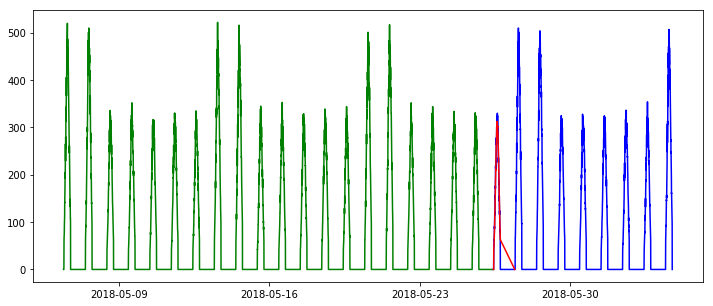

trainning started for attraction: 1


/Users/d069325/q-learning/q-learning/Cebit_Timeseries_Forecast/random_forest_forecast_class.py:23: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  data_frame = DataFrame.from_csv(filename, header=0) # car-sales.csv


trainning finished for attraction: 1
predict ahead started for attraction: 1
predict ahead finished for attraction: 1
Test MSE: 49.977


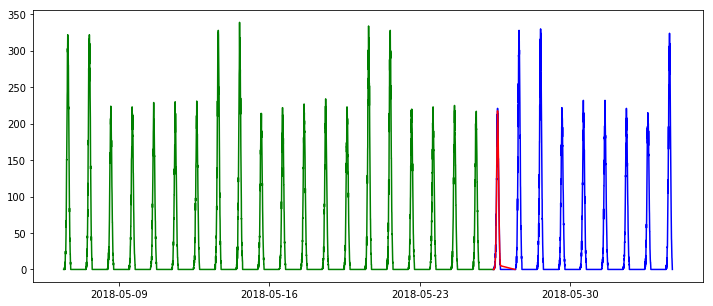

trainning started for attraction: 2


/Users/d069325/q-learning/q-learning/Cebit_Timeseries_Forecast/random_forest_forecast_class.py:23: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  data_frame = DataFrame.from_csv(filename, header=0) # car-sales.csv


trainning finished for attraction: 2
predict ahead started for attraction: 2
predict ahead finished for attraction: 2
Test MSE: 76.828


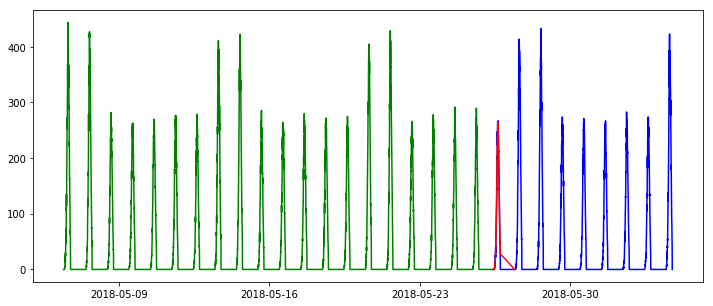

trainning started for attraction: 3


/Users/d069325/q-learning/q-learning/Cebit_Timeseries_Forecast/random_forest_forecast_class.py:23: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  data_frame = DataFrame.from_csv(filename, header=0) # car-sales.csv


trainning finished for attraction: 3
predict ahead started for attraction: 3
predict ahead finished for attraction: 3
Test MSE: 44.463


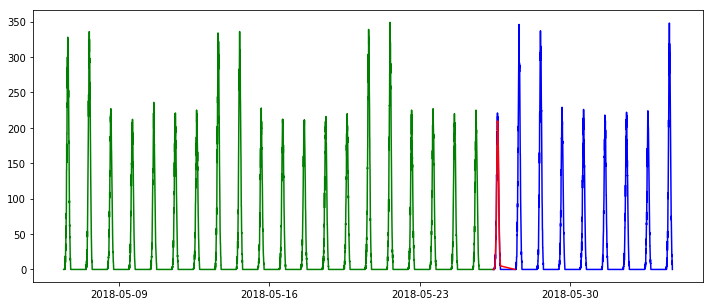

trainning started for attraction: 4


/Users/d069325/q-learning/q-learning/Cebit_Timeseries_Forecast/random_forest_forecast_class.py:23: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  data_frame = DataFrame.from_csv(filename, header=0) # car-sales.csv


trainning finished for attraction: 4
predict ahead started for attraction: 4
predict ahead finished for attraction: 4
Test MSE: 24.158


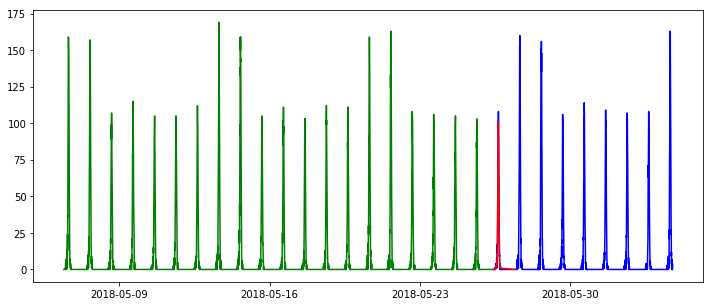

trainning started for attraction: 5


/Users/d069325/q-learning/q-learning/Cebit_Timeseries_Forecast/random_forest_forecast_class.py:23: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  data_frame = DataFrame.from_csv(filename, header=0) # car-sales.csv


trainning finished for attraction: 5
predict ahead started for attraction: 5
predict ahead finished for attraction: 5
Test MSE: 95.716


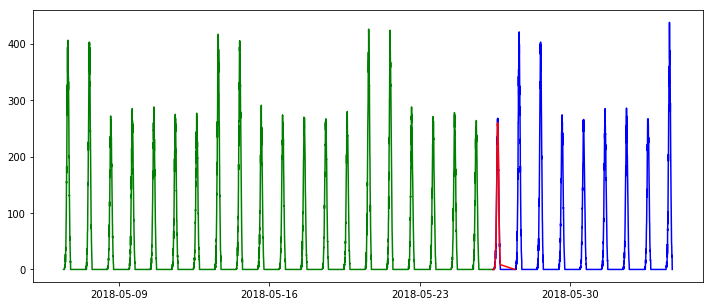

trainning started for attraction: 6


/Users/d069325/q-learning/q-learning/Cebit_Timeseries_Forecast/random_forest_forecast_class.py:23: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  data_frame = DataFrame.from_csv(filename, header=0) # car-sales.csv


trainning finished for attraction: 6
predict ahead started for attraction: 6
predict ahead finished for attraction: 6
Test MSE: 117.363


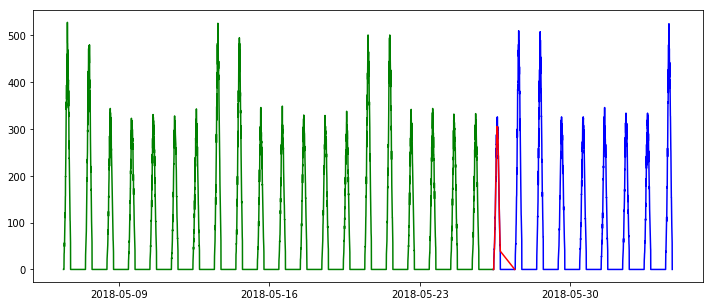

trainning started for attraction: 7


/Users/d069325/q-learning/q-learning/Cebit_Timeseries_Forecast/random_forest_forecast_class.py:23: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  data_frame = DataFrame.from_csv(filename, header=0) # car-sales.csv


trainning finished for attraction: 7
predict ahead started for attraction: 7
predict ahead finished for attraction: 7
Test MSE: 184.861


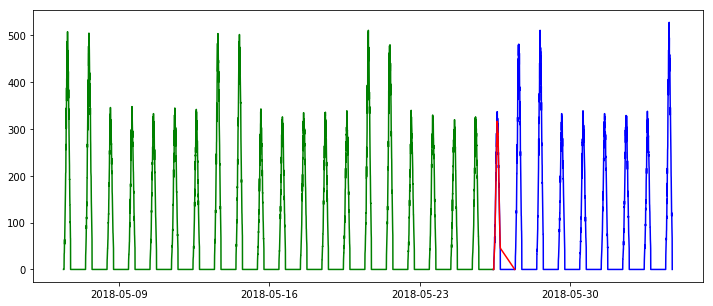

trainning started for attraction: 8


/Users/d069325/q-learning/q-learning/Cebit_Timeseries_Forecast/random_forest_forecast_class.py:23: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  data_frame = DataFrame.from_csv(filename, header=0) # car-sales.csv


trainning finished for attraction: 8
predict ahead started for attraction: 8
predict ahead finished for attraction: 8
Test MSE: 55.797


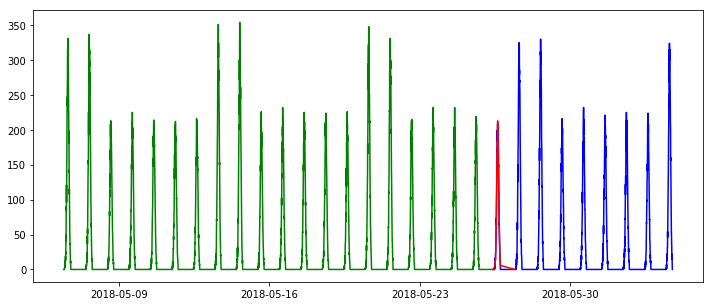

/Users/d069325/q-learning/q-learning/Cebit_Timeseries_Forecast/random_forest_forecast_class.py:23: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  data_frame = DataFrame.from_csv(filename, header=0) # car-sales.csv


trainning started for attraction: 9
trainning finished for attraction: 9
predict ahead started for attraction: 9
predict ahead finished for attraction: 9
Test MSE: 38.537


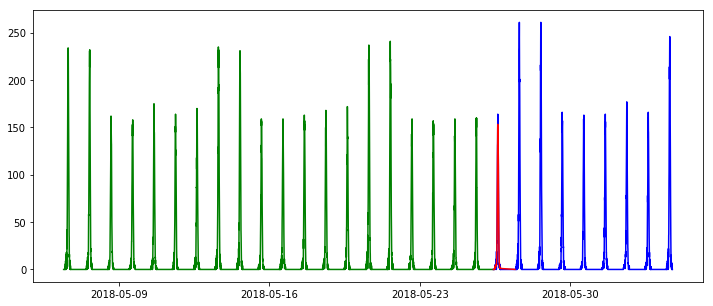

/Users/d069325/q-learning/q-learning/Cebit_Timeseries_Forecast/random_forest_forecast_class.py:23: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  data_frame = DataFrame.from_csv(filename, header=0) # car-sales.csv


trainning started for attraction: 10
trainning finished for attraction: 10
predict ahead started for attraction: 10
predict ahead finished for attraction: 10
Test MSE: 76.521


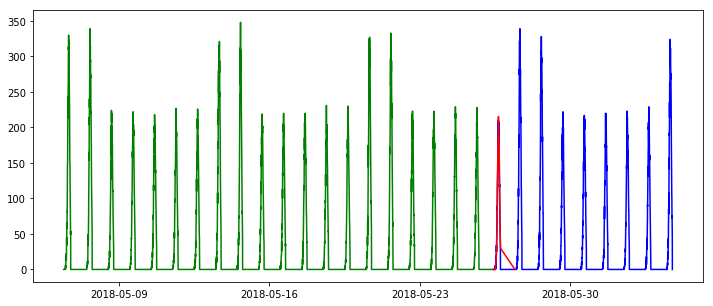

trainning started for attraction: 11


/Users/d069325/q-learning/q-learning/Cebit_Timeseries_Forecast/random_forest_forecast_class.py:23: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  data_frame = DataFrame.from_csv(filename, header=0) # car-sales.csv


trainning finished for attraction: 11
predict ahead started for attraction: 11
predict ahead finished for attraction: 11
Test MSE: 15.743


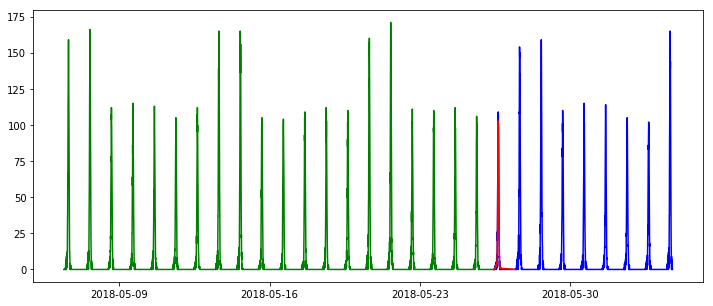

trainning started for attraction: 12


/Users/d069325/q-learning/q-learning/Cebit_Timeseries_Forecast/random_forest_forecast_class.py:23: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  data_frame = DataFrame.from_csv(filename, header=0) # car-sales.csv


trainning finished for attraction: 12
predict ahead started for attraction: 12
predict ahead finished for attraction: 12
Test MSE: 33.035


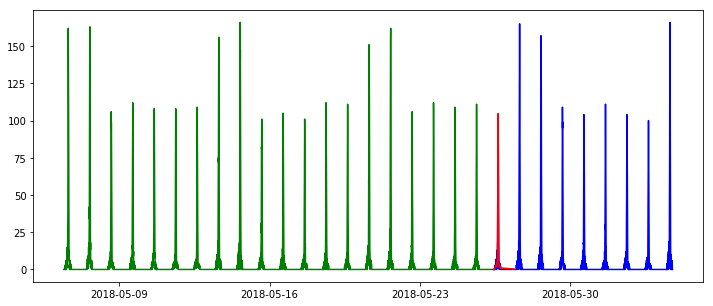

trainning started for attraction: 13


/Users/d069325/q-learning/q-learning/Cebit_Timeseries_Forecast/random_forest_forecast_class.py:23: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  data_frame = DataFrame.from_csv(filename, header=0) # car-sales.csv


trainning finished for attraction: 13
predict ahead started for attraction: 13
predict ahead finished for attraction: 13
Test MSE: 21.549


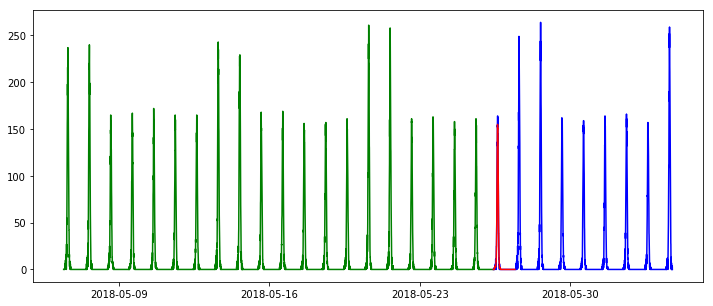

trainning started for attraction: 14


/Users/d069325/q-learning/q-learning/Cebit_Timeseries_Forecast/random_forest_forecast_class.py:23: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  data_frame = DataFrame.from_csv(filename, header=0) # car-sales.csv


trainning finished for attraction: 14
predict ahead started for attraction: 14
predict ahead finished for attraction: 14
Test MSE: 102.343


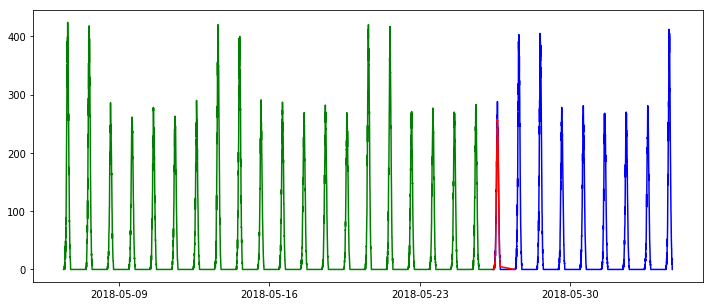

trainning started for attraction: 15


/Users/d069325/q-learning/q-learning/Cebit_Timeseries_Forecast/random_forest_forecast_class.py:23: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  data_frame = DataFrame.from_csv(filename, header=0) # car-sales.csv


trainning finished for attraction: 15
predict ahead started for attraction: 15
predict ahead finished for attraction: 15
Test MSE: 337.015


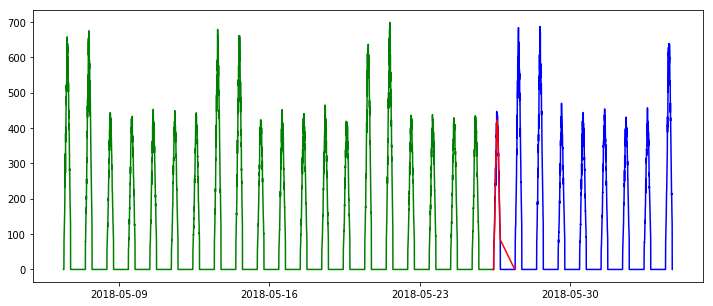

trainning started for attraction: 16


/Users/d069325/q-learning/q-learning/Cebit_Timeseries_Forecast/random_forest_forecast_class.py:23: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  data_frame = DataFrame.from_csv(filename, header=0) # car-sales.csv


trainning finished for attraction: 16
predict ahead started for attraction: 16
predict ahead finished for attraction: 16
Test MSE: 16.995


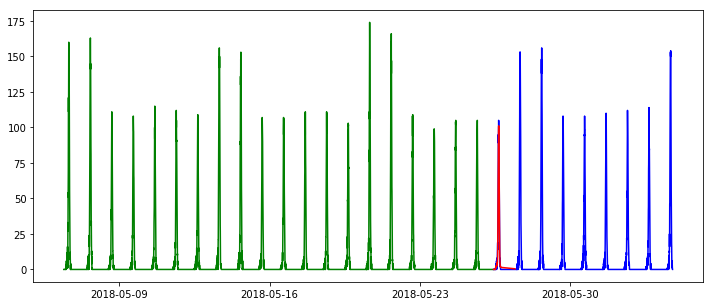

trainning started for attraction: 17


/Users/d069325/q-learning/q-learning/Cebit_Timeseries_Forecast/random_forest_forecast_class.py:23: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  data_frame = DataFrame.from_csv(filename, header=0) # car-sales.csv


trainning finished for attraction: 17
predict ahead started for attraction: 17
predict ahead finished for attraction: 17
Test MSE: 66.793


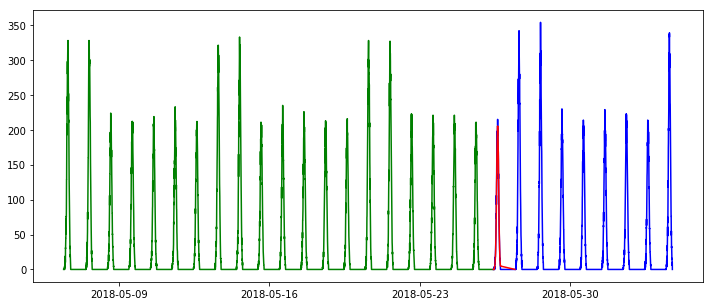

trainning started for attraction: 18


/Users/d069325/q-learning/q-learning/Cebit_Timeseries_Forecast/random_forest_forecast_class.py:23: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  data_frame = DataFrame.from_csv(filename, header=0) # car-sales.csv


trainning finished for attraction: 18
predict ahead started for attraction: 18
predict ahead finished for attraction: 18
Test MSE: 7.945


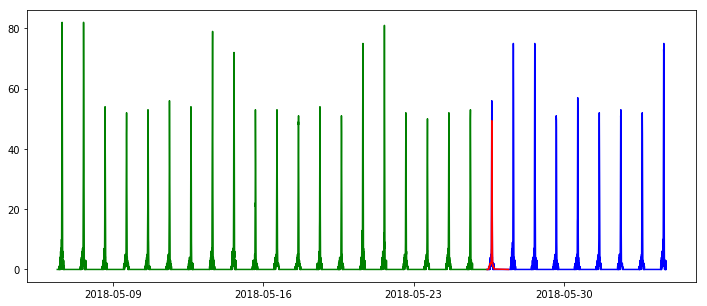

Episode 999
Rewards -71.67961456582633
State sequence [0, 1, 19, 18, 17, 16, 14, 9, 8, 10, 11, 12, 13, 15, 4, 3, 2, 5, 6, 7, 20]
Epsilon {6.89604010498022e-88}
Q matrix
[[ 0.00000000e+00 -3.93600000e+00 -4.25638996e+00 -3.95768400e+00
  -4.65361200e+00 -4.48248000e+00 -4.92936000e+00 -4.53492000e+00
  -4.06068000e+00 -5.16417600e+00 -5.53490400e+00 -3.96264000e+00
  -4.97881200e+00 -4.76141580e+00 -4.53654000e+00 -4.78708800e+00
  -4.45281720e+00 -4.27989823e+00 -4.13873131e+00 -3.96514440e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -4.39524565e+00 -4.99562675e+00
  -4.99156402e+00 -5.52361766e+00 -4.36922382e+00 -9.15651989e+00
  -1.35540724e+01 -4.33140656e+00 -4.73153814e+00 -4.88615401e+00
  -5.49954320e+00 -5.11660009e+00 -4.81427445e+00 -4.91645545e+00
  -1.24444352e+01 -4.40443285e+00 -4.30036611e+00 -4.24459575e+00
  -1.00000000e+05]
 [ 0.00000000e+00 -5.09748679e+00  0.00000000e+00 -2.10335309e+01
  -2.11849303e+01 -3.47082460e+01 -3.62192313e+01 -3.81509397e+01
 

[0, 1, 19, 18, 17, 16, 14, 9, 8, 10, 11, 12, 13, 15, 4, 3, 2, 5, 6, 7, 20]

In [3]:
import pandas as pd
import numpy as np
from Cebit_TSP.qlearning import q_learning
from Cebit_Timeseries_Forecast.random_forest_forecast_class import RandomForestForecast
import matplotlib
from matplotlib import pyplot
%matplotlib inline
pyplot.rcParams["figure.figsize"] =(12,5) 

ATTRACTIONS_NUMBER = 19
QUEUE_SIZE_TIME_STEP_MEASURMENT = 5
MAX_TIME = 480 # the number of minutes in a day that the fun-park is opened
TRAINING_WINDOW_SIZE = 96

estimators = []
start_state = 0
end_state = 20
rewards = "example/walking_rewards.csv"

waiting_rewards = []

for i in range(ATTRACTIONS_NUMBER):
    estimators.append(RandomForestForecast('Cebit_Timeseries_Forecast/queue_sizes.csv', i, TRAINING_WINDOW_SIZE))
    estimators[i].train()
    waiting_rewards.append(estimators[i].predict_look_ahead(int(MAX_TIME/QUEUE_SIZE_TIME_STEP_MEASURMENT))) 
    estimators[i].display_results()

rewards = pd.read_csv(rewards, header=None)
rewards = abs(rewards) * -1

attractions_throughput = pd.read_csv("example/attractions_throughput.csv", header=None)
attractions_throughput = attractions_throughput[0]

q_learning(
        R=rewards,
        R_waiting=waiting_rewards,
        attractions_throughput=attractions_throughput,
        time_step=QUEUE_SIZE_TIME_STEP_MEASURMENT,
        max_time=MAX_TIME,
        start_state=start_state,
        end_state=end_state)

# API documentation

Please, find below three webservices necessary to solve the problem of finding a path in the fun-park. Each team has own webservices and the url for each team has to be adjusted accordingly by filling <SPACE_NUMBER>.

You can also modify the code of webservices as you wish. To do that adjust the code, go to the folder of the desired webservice (Cebit_Datagenerator, Cebit_Timeseries_Forecast, Cebit_TSP), fill the name of the webservice in the `manifest.yml` file (especially adjust <SPACE_NUMBER>) and run the command: `cf push`

To see the logs of the webservice, run the command: 
* `cf logs ml-cebit-<SPACE_NUMBER>-tsp --recent`
* `cf logs ml-cebit-<SPACE_NUMBER>-timeseries --recent`
* `cf logs ml-cebit-<SPACE_NUMBER>-data-generator --recent`

### Data Generator - API

`Base URL`: https://ml-cebit-<SPACE_NUMBER>-data-generator.cfapps.eu10.hana.ondemand.com

`path`: /sensorData `GET`


`parameters`:
* `attractionsNumber` - number of attractions in the fun-park (default 19)
* `numOfDays` - number of days when sensors data was gathered (default 30)
* `openingHour` - the hour when the fun-park openes each day (default 10)
* `startYear` - year of the sensors data collection start (default 2018)
* `startMonth` - months of the sensors data collection start (default 5)
* `startDay` - day of the sensors data collection start (default 4)
* `parkOpeningMinutes` - number of minutes when the fun-park is opened (default 480)
* `sensorsMinuteStep` - step/gap in minutes between two consequtive sensors measurments (defualt 5)


```console
curl https://ml-cebit-<SPACE_NUMBER>-data-generator.cfapps.eu10.hana.ondemand.com/sensorData -o queue_sizes.csv
```
```console
curl https://ml-cebit-<SPACE_NUMBER>-data-generator.cfapps.eu10.hana.ondemand.com/sensorData?numOfDays=2 -o queue_sizes.csv
```

### Time series forecast - API

Asynchronous communication, as the job runs more than 10 minutes

`Base URL`: https://ml-cebit-<SPACE_NUMBER>-timeseries.cfapps.eu10.hana.ondemand.com

`path`: /forecastTrigger `POST`


`parameters:`
* `attractionsNumber` - number of attractions in the fun-park (default 1)
* `trainingWindowSize` - window size for time delay ML estimator. It determines the number of historical time steps taken into single iteration of training (default 96)
* `parkOpeningMinutes` - number of minutes when the fun-park is opened (default 480)
* `sensorsMinuteStep` - step/gap in minutes between two consequtive sensors measurments (defualt 5)
* `training_set_end_date` - datetime when the training set ends (only points until this datetime will be included in training) (default '2018-05-26 10:05:00')
* `file` - file obtained from the https://ml-cebit-<SPACE_NUMBER>-data-generator.cfapps.eu10.hana.ondemand.com/sensorData endpoint


`Base URL`: https://ml-cebit-<SPACE_NUMBER>-timeseries.cfapps.eu10.hana.ondemand.com

`path`: /forecastGetResult `GET`


`parameters`:
* `jobId` - id of the job obtained from the /forecastGetResult endpoint


```console
curl -X POST https://ml-cebit-<SPACE_NUMBER>-timeseries.cfapps.eu10.hana.ondemand.com/forecastTrigger -F 'file=@queue_sizes.csv' -F "attractionsNumber=19"
```

copy jobId, for example: `89b70404-e248-4cdd-aaab-fff64e2776ce` and query for the result. The result is returned once the job finishes, otherwise you get 'Job Pending'.

```console
curl -X GET https://ml-cebit-<SPACE_NUMBER>-timeseries.cfapps.eu10.hana.ondemand.com/forecastGetResult?jobId=89b70404-e248-4cdd-aaab-fff64e2776ce -o waiting_rewards.json
```

### Travelling salesman problem - API

`Base URL`: https://ml-cebit-<SPACE_NUMBER>-tsp.cfapps.eu10.hana.ondemand.com

`path`: /find `POST`


`parameters:`
* `file_walking_rewards` - file containing walking times between each attraction (adjacency matrix)
* `file_waiting_rewards` - file obtained from the https://ml-cebit-<SPACE_NUMBER>-timeseries.cfapps.eu10.hana.ondemand.com/forecastGetResult endpoint
* `startState` - start state for the route planning (default 0 - fun-park entrance)
* `endState` - end state for the route planning (default 20 - fun-park exit)

```console
curl -X POST https://ml-cebit-<SPACE_NUMBER>-tsp.cfapps.eu10.hana.ondemand.com/find -F 'file_walking_rewards=@walking_rewards.csv' -F 'file_waiting_rewards=@waiting_rewards.json' -F "startState=0" -F "endState=20" -F "attractionsNumber=19"
```
